# Sheet 5

## 2 Logistic regression: an LLM lie detector

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use `add_dataset` multiple times on the same data manager if you want to combine datasets.

In [1]:
import torch as t
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

torch.Size([1196, 4096]) torch.Size([1196])


In [3]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

                                        statement  label       city  \
0             The city of Krasnodar is in Russia.      1  Krasnodar   
1       The city of Krasnodar is in South Africa.      0  Krasnodar   
2                  The city of Lodz is in Poland.      1       Lodz   
3  The city of Lodz is in the Dominican Republic.      0       Lodz   
4            The city of Maracay is in Venezuela.      1    Maracay   
5                The city of Maracay is in China.      0    Maracay   
6              The city of Baku is in Azerbaijan.      1       Baku   
7                 The city of Baku is in Ukraine.      0       Baku   
8                  The city of Baoji is in China.      1      Baoji   
9              The city of Baoji is in Guatemala.      0      Baoji   

                  country correct_country  
0                  Russia          Russia  
1            South Africa          Russia  
2                  Poland          Poland  
3  the Dominican Republic          Poland 

### (a)

In [4]:
# Create and train the Logistic Regression model
model = LogisticRegression(penalty=None, max_iter=1000)  # No regularization
model.fit(acts_train, labels_train) 

predictions = model.predict(acts_test)

accuracy = accuracy_score(labels_test, predictions)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Test set accuracy: 100.00%


We get an accuracy of 100 % for all four data sets, so the activation vectors are linearly separable.

### (b)

In [5]:
# Train on cities dataset
train_dataset = "cities"
dm.add_dataset(train_dataset, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set

In [6]:
# No regularization

# Create and train the Logistic Regression model
model = LogisticRegression(penalty=None, max_iter=1000)
model.fit(acts_train, labels_train)

# Evaluate on other datasets
for test_dataset in dataset_names:
    if test_dataset == train_dataset:
        continue
    dm.add_dataset(test_dataset, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_test, labels_test = dm.get('val')
    predictions = model.predict(acts_test)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"Test set accuracy on {test_dataset}: {accuracy * 100:.2f}%")

Test set accuracy on neg_cities: 74.50%
Test set accuracy on sp_en_trans: 74.96%
Test set accuracy on neg_sp_en_trans: 73.18%


In [7]:
# With regularization

# Create and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)  # With regularization
model.fit(acts_train, labels_train)

# Evaluate on other datasets
for test_dataset in dataset_names:
    if test_dataset == train_dataset:
        continue
    dm.add_dataset(test_dataset, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_test, labels_test = dm.get('val')
    predictions = model.predict(acts_test)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"Test set accuracy on {test_dataset}: {accuracy * 100:.2f}%")

Test set accuracy on neg_cities: 75.07%
Test set accuracy on sp_en_trans: 75.07%
Test set accuracy on neg_sp_en_trans: 74.80%


We can observe that all performances are >50%, so the results are above chance, yet do not fully generalize to other topics. We can further see that the accuracy drops when negation is introduced.

### (c)

In [8]:
# Combine cities and neg cities datasets for training
train_datasets = ["cities", "neg_cities"]
acts_train_list = []
labels_train_list = []  
for dataset in train_datasets:
    dm.add_dataset(dataset, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts, labels = dm.get('train')
    acts_train_list.append(acts)
    labels_train_list.append(labels)
acts_train = np.concatenate(acts_train_list)
labels_train = np.concatenate(labels_train_list)

In [9]:
# Create and train the Logistic Regression model
model = LogisticRegression(penalty=None, max_iter=1000)  # No regularization
model.fit(acts_train, labels_train) 

# Evaluate on sp_en_trans and neg_sp_en_trans datasets
test_datasets = ["sp_en_trans", "neg_sp_en_trans"]
for test_dataset in test_datasets:  
    dm.add_dataset(test_dataset, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_test, labels_test = dm.get('val')
    predictions = model.predict(acts_test)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"Test set accuracy on {test_dataset}: {accuracy * 100:.2f}%")

Test set accuracy on sp_en_trans: 99.87%
Test set accuracy on neg_sp_en_trans: 99.87%


## 3 Log-sum-exp and soft(arg)max
### (b)

In [10]:
def lse(z, lmb):
    sum = 0
    for i in range(z.shape[0]):
        sum += np.exp(z[i] * lmb)
    return np.log(sum) / lmb

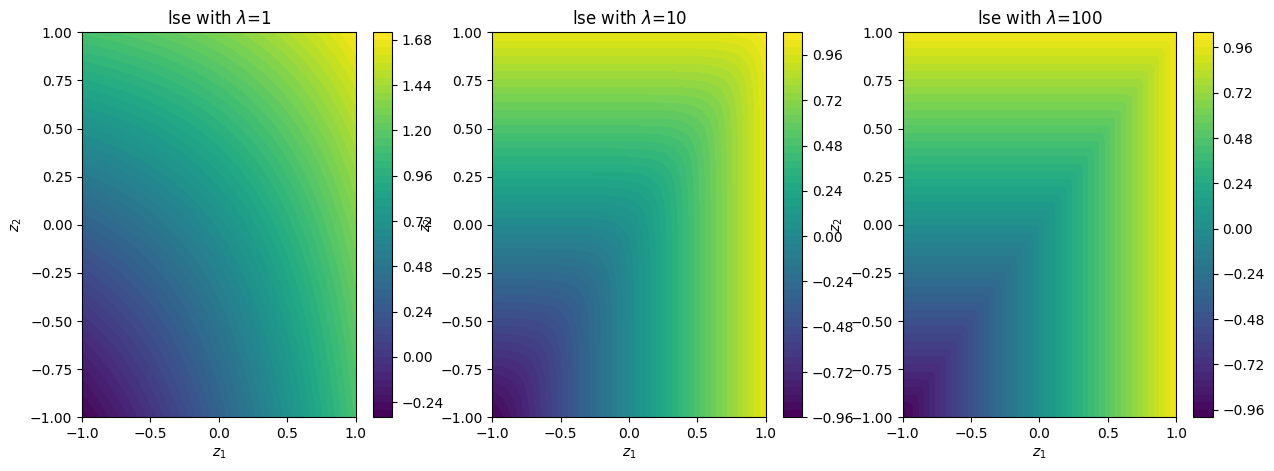

In [11]:
z1 = np.linspace(-1, 1, 100)    
z2 = np.linspace(-1, 1, 100)
Z1, Z2 = np.meshgrid(z1, z2)

lambdas = [1, 10, 100]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx, lmb in enumerate(lambdas):
    Z_lse = np.vectorize(lambda z1, z2: lse(np.array([z1, z2]), lmb))(Z1, Z2)
    cs = axs[idx].contourf(Z1, Z2, Z_lse, levels=50)
    axs[idx].set_title(f'lse with $\\lambda$={lmb}')
    axs[idx].set_xlabel('$z_1$')
    axs[idx].set_ylabel('$z_2$')
    fig.colorbar(cs, ax=axs[idx])

plt.show()

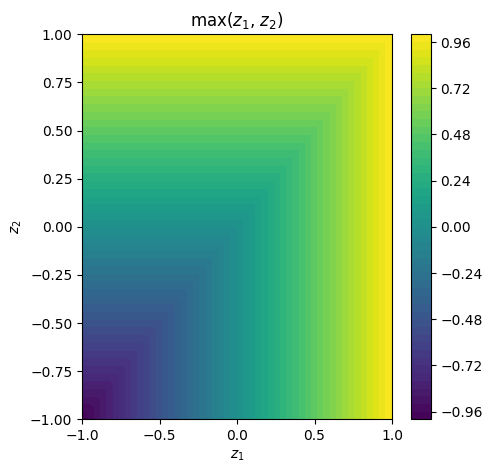

In [12]:
Z_max = np.maximum(Z1, Z2)

plt.figure(figsize=(5, 5))

cs = plt.contourf(Z1, Z2, Z_max, levels=50)
plt.title('max($z_1$, $z_2$)')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.colorbar(cs)

plt.show()

We can see that the higher $\lambda$ gets, the closer the contour gets to a max($z_1$, $z_2$)-contour

### (c)

In [13]:
def soft_arg_max(z, lmb, k):
    sum = 0
    for i in range(z.shape[0]):
        sum += np.exp(lmb * z[i])
    return np.exp(lmb * z[k])/sum

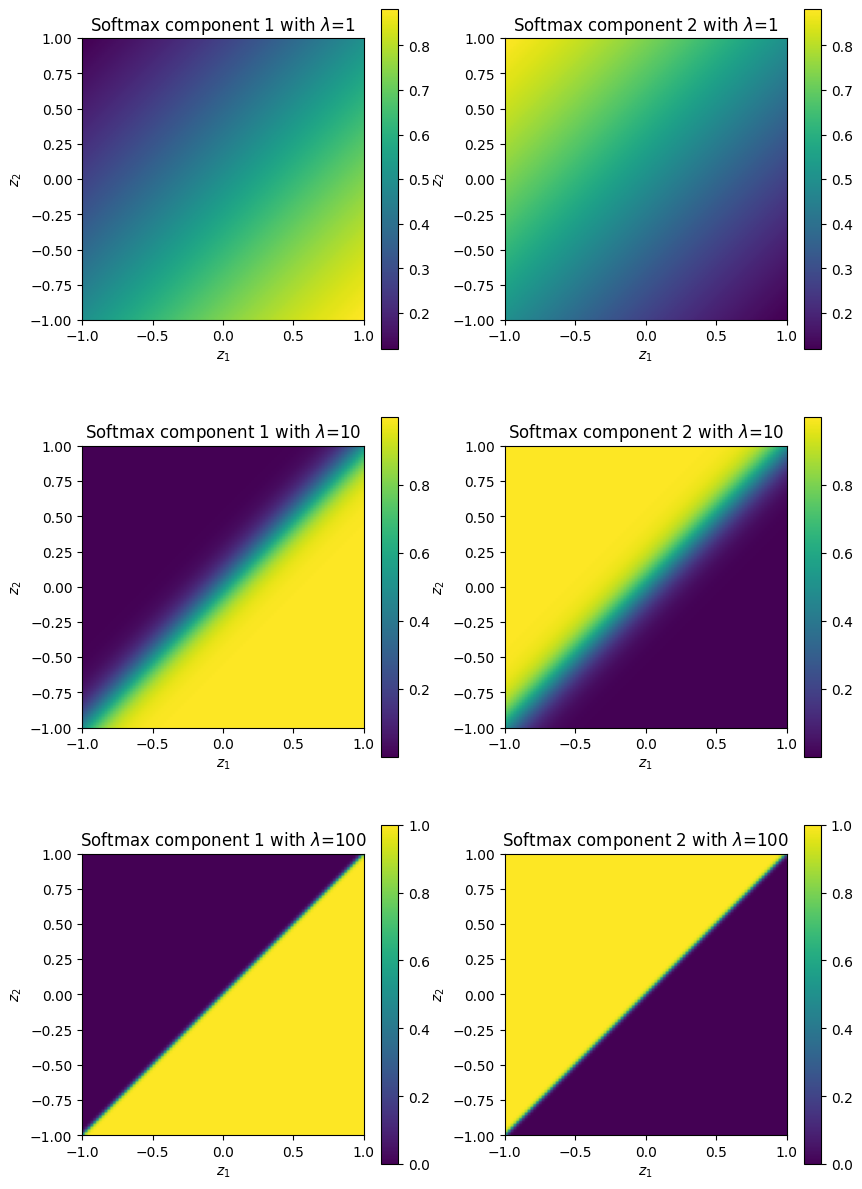

In [14]:
z1 = np.linspace(-1, 1, 100)    
z2 = np.linspace(-1, 1, 100)
Z1, Z2 = np.meshgrid(z1, z2)

lambdas = [1, 10, 100]

fig, axs = plt.subplots(3, 2, figsize=(10, 15))

for idx, lmb in enumerate(lambdas):
    Z_softmax_1 = np.vectorize(lambda z1, z2: soft_arg_max(np.array([z1, z2]), lmb, 0))(Z1, Z2)
    Z_softmax_2 = np.vectorize(lambda z1, z2: soft_arg_max(np.array([z1, z2]), lmb, 1))(Z1, Z2)
    
    cs1 = axs[idx, 0].imshow(Z_softmax_1, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    axs[idx, 0].set_title(f'Softmax component 1 with $\\lambda$={lmb}')
    axs[idx, 0].set_xlabel('$z_1$')
    axs[idx, 0].set_ylabel('$z_2$')
    fig.colorbar(cs1, ax=axs[idx, 0])
    
    cs2 = axs[idx, 1].imshow(Z_softmax_2, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    axs[idx, 1].set_title(f'Softmax component 2 with $\\lambda$={lmb}')
    axs[idx, 1].set_xlabel('$z_1$')
    axs[idx, 1].set_ylabel('$z_2$')
    fig.colorbar(cs2, ax=axs[idx, 1])
    
plt.show()

## 4 Linear regions of MLPs

### (a)

In [15]:
class ShallowMLP(t.nn.Module):
    def __init__(self):
        super(ShallowMLP, self).__init__()
        self.hidden = t.nn.Linear(2, 20)
        self.output = t.nn.Linear(20, 1)
        self.relu = t.nn.ReLU()
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x
model = ShallowMLP()
print(model)

ShallowMLP(
  (hidden): Linear(in_features=2, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)


In [16]:
total_params = sum(p.numel() for p in model.parameters())

print(f'The model has {total_params} parameters.')

The model has 81 parameters.


### (b)

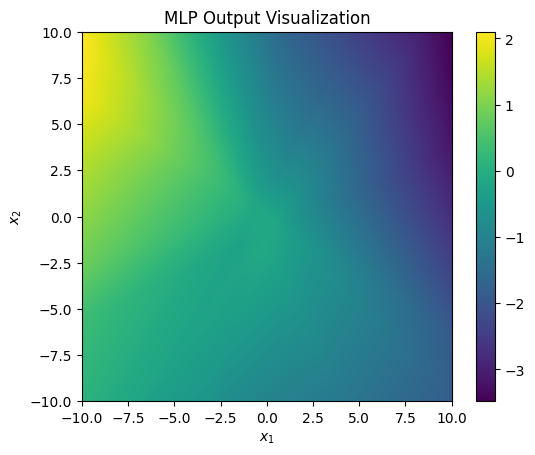

In [17]:
x1 = np.linspace(-10, 10, 500)
x2 = np.linspace(-10, 10, 500)
X1, X2 = np.meshgrid(x1, x2)

inputs = np.vstack([X1.ravel(), X2.ravel()]).T
inputs_tensor = t.tensor(inputs, dtype=t.float32)
outputs = model(inputs_tensor).detach().numpy().reshape(500, 500)

plt.imshow(outputs, extent=(-10, 10, -10, 10), origin='lower')
plt.colorbar()
plt.title('MLP Output Visualization')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()

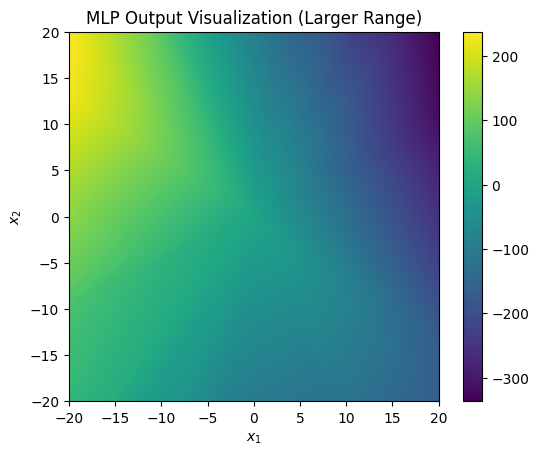

In [18]:
# Larger Range
range=1000
x1 = np.linspace(-range, range, 500)
x2 = np.linspace(-range, range, 500)  
X1, X2 = np.meshgrid(x1, x2)

inputs = np.vstack([X1.ravel(), X2.ravel()]).T
inputs_tensor = t.tensor(inputs, dtype=t.float32)
outputs = model(inputs_tensor).detach().numpy().reshape(500, 500)

plt.imshow(outputs, extent=(-20, 20, -20, 20), origin='lower')
plt.colorbar()
plt.title('MLP Output Visualization (Larger Range)')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()

### (c)

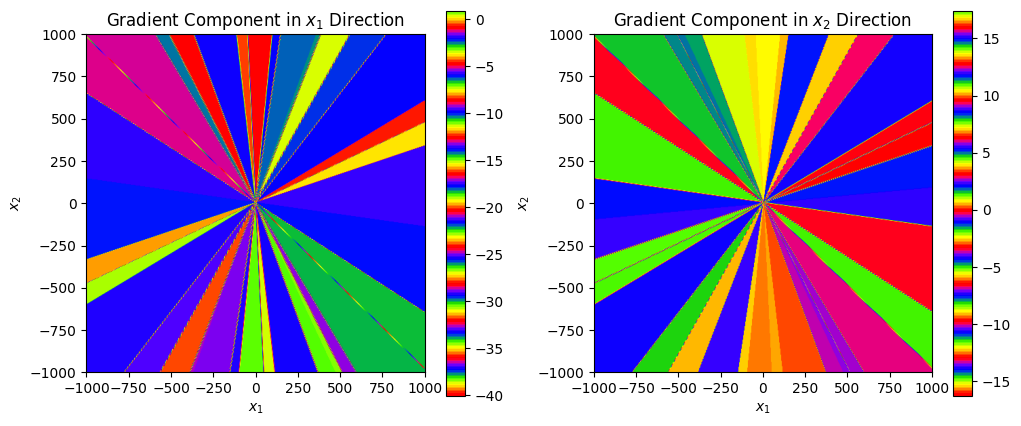

In [19]:
range=10
x1 = np.linspace(-range, range, 500)
x2 = np.linspace(-range, range, 500)  
X1, X2 = np.meshgrid(x1, x2)

grad_y, grad_x = np.gradient(outputs, x1, x2)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(grad_x, extent=(-1000, 1000, -1000, 1000), origin='lower', cmap='prism')
plt.colorbar()
plt.title('Gradient Component in $x_1$ Direction')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.subplot(1, 2, 2)
plt.imshow(grad_y, extent=(-1000, 1000, -1000, 1000), origin='lower', cmap='prism')
plt.colorbar()
plt.title('Gradient Component in $x_2$ Direction')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()

### (d)

In [20]:
class DeepMLP(t.nn.Module):
    def __init__(self):
        super(DeepMLP, self).__init__()
        self.hidden1 = t.nn.Linear(2, 5)
        self.hidden2 = t.nn.Linear(5, 5)
        self.hidden3 = t.nn.Linear(5, 5)
        self.hidden4 = t.nn.Linear(5, 5)
        self.output = t.nn.Linear(5, 1)
        self.relu = t.nn.ReLU()
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.hidden3(x)
        x = self.relu(x)
        x = self.hidden4(x)
        x = self.relu(x)
        x = self.output(x)
        return x
    
model = DeepMLP()

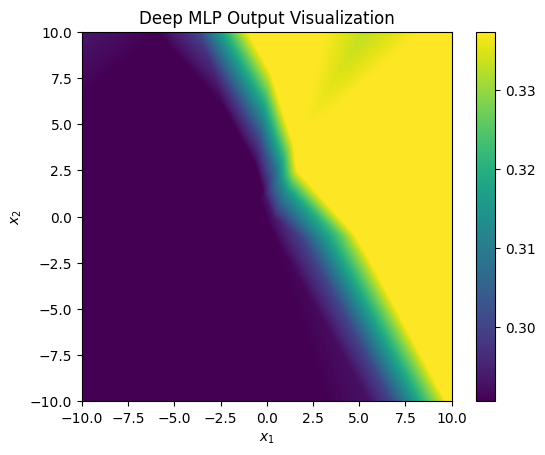

In [21]:
x1 = np.linspace(-10, 10, 500)
x2 = np.linspace(-10, 10, 500)
X1, X2 = np.meshgrid(x1, x2)

inputs = np.vstack([X1.ravel(), X2.ravel()]).T
inputs_tensor = t.tensor(inputs, dtype=t.float32)
outputs = model(inputs_tensor).detach().numpy().reshape(500, 500)

plt.imshow(outputs, extent=(-10, 10, -10, 10), origin='lower')
plt.colorbar()
plt.title('Deep MLP Output Visualization')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

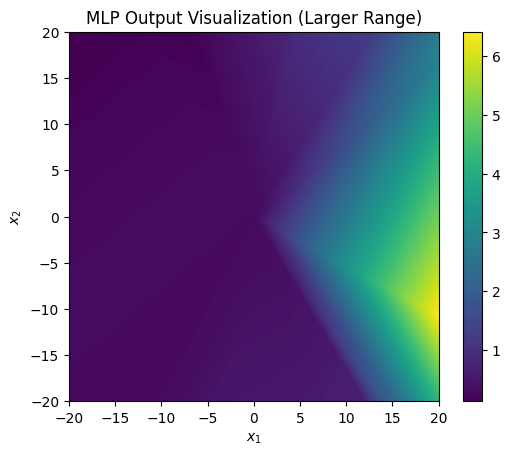

In [22]:
# Larger Range
range=1000
x1 = np.linspace(-range, range, 500)
x2 = np.linspace(-range, range, 500)  
X1, X2 = np.meshgrid(x1, x2)

inputs = np.vstack([X1.ravel(), X2.ravel()]).T
inputs_tensor = t.tensor(inputs, dtype=t.float32)
outputs = model(inputs_tensor).detach().numpy().reshape(500, 500)

plt.imshow(outputs, extent=(-20, 20, -20, 20), origin='lower')
plt.colorbar()
plt.title('MLP Output Visualization (Larger Range)')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()

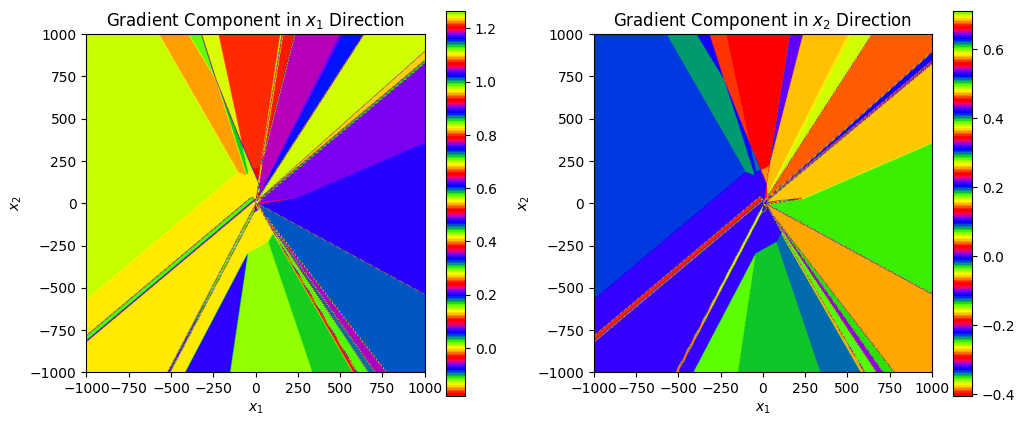

In [23]:
range=10
x1 = np.linspace(-range, range, 500)
x2 = np.linspace(-range, range, 500)  
X1, X2 = np.meshgrid(x1, x2)

grad_y, grad_x = np.gradient(outputs, x1, x2)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(grad_x, extent=(-1000, 1000, -1000, 1000), origin='lower', cmap='prism')
plt.colorbar()
plt.title('Gradient Component in $x_1$ Direction')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.subplot(1, 2, 2)
plt.imshow(grad_y, extent=(-1000, 1000, -1000, 1000), origin='lower', cmap='prism')
plt.colorbar()
plt.title('Gradient Component in $x_2$ Direction')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()

looks more chaotic